# Bivariate Analysis of SIF and XCO2
---

In [2]:
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
import seaborn as sns

## Data processing

In [11]:
def prep_sif(ds):
    """Preprocess a SIF Lite file"""
    
    # Drop unused variables
    variable_list = ["Daily_SIF_740nm", "SIF_Uncertainty_740nm", "Quality_Flag", "Longitude", "Latitude", "Delta_Time"]
    ds = ds[variable_list]
    
    # Apply quality filters
    ds["SIF_plus_3sig"] = ds.Daily_SIF_740nm + 3*ds.SIF_Uncertainty_740nm
    ds = ds.where(ds.Quality_Flag != 2, drop=True)
    ds = ds.where(ds.SIF_plus_3sig > 0, drop=True)

    # Format dataset
    dsnew = xarray.Dataset(
        {
            "sif": (["time"], ds.Daily_SIF_740nm),
        },
        coords={
            "lon": (["time"], ds.Longitude),
            "lat": (["time"], ds.Latitude),
            "time": ds.Delta_Time.values
        }
    )
    return dsnew


def prep_xco2(ds):
    """Preprocess an FP Lite file"""
    
    # Drop unused variables
    variable_list = ["xco2", "xco2_quality_flag", "longitude", "latitude", "time"]
    ds = ds[variable_list]
    
    # Apply quality filters
    ds = ds.where(ds.xco2_quality_flag == 0, drop=True)

    # Format dataset
    dsnew = xarray.Dataset(
        {
            "xco2": (["time"], ds.xco2),
        },
        coords={
            "lon": (["time"], ds.longitude),
            "lat": (["time"], ds.latitude),
            "time": ds.time.values
        }
    )
    return dsnew
    
    
def aggregate_grid(ds):
    # Map lat-lon to 1-degree bins
    lon_bins = np.arange(-180, 181)
    lat_bins = np.arange(-85, 86)
    lon_centers = np.arange(-179.5, 180.5)
    lat_centers = np.arange(-84.5, 85.5)
    
    df = ds.to_dataframe()
    df["lon"] = pd.cut(df.lon, lon_bins, labels=lon_centers).astype(float)
    df["lat"] = pd.cut(df.lat, lat_bins, labels=lat_centers).astype(float)

    # Group by bins, compute mean, return data array
    return df.groupby(["lon", "lat"]).mean().to_xarray()

# def apply_ocean_mask(ds):
#     # Consider writing this so it returns a data array that can be assigned to dataset without needing to overwrite
#     # Create mask variable for *gridded* dataset {land: True, ocean: False}
#     land = regionmask.defined_regions.natural_earth.land_110
#     ds["ocean_mask"] = land.mask(ds)
#     ds.ocean_mask.values = ~np.array(ds.ocean_mask, dtype=bool)
#     return ds

In [44]:
# Open datasets for 2016
paths_sif = "../data/OCO2_L2_Lite_SIF_10r/2016/*.nc4"
paths_xco2 = "../data/OCO2_L2_Lite_FP_10r/2016/*.nc4"

DS_sif = xarray.open_mfdataset(paths_sif, preprocess=prep_sif, parallel=True)
DS_xco2 = xarray.open_mfdataset(paths_xco2, preprocess=prep_xco2, parallel=True)

In [45]:
# Aggregate both datasets to 1-degree monthly averages
DS_sif_grid = DS_sif.resample(time="1MS").map(aggregate_grid)
DS_xco2_grid = DS_xco2.resample(time="1MS").map(aggregate_grid)

In [46]:
# Create a data frame joining SIF and XCO2 by coordinates
df_sif = DS_sif_grid.to_dataframe().dropna()
df_xco2 = DS_xco2_grid.to_dataframe().dropna()
df = pd.merge(df_sif, df_xco2, how="inner", on=["lon", "lat", "time"]).reset_index()
df["time"] = df.time.dt.strftime("%Y-%m")
df.sort_values(by="time", inplace=True)

In [47]:
df.head()

,lon,lat,time,sif,xco2
26849,40.5,10.5,2016-01,0.068731,402.504669
49446,-8.5,37.5,2016-01,0.183045,403.918671
25906,48.5,8.5,2016-01,0.099937,402.354767
49441,-25.5,37.5,2016-01,0.212845,403.140167
5720,-49.5,-28.5,2016-01,0.505454,396.561188


## Bivariate analysis

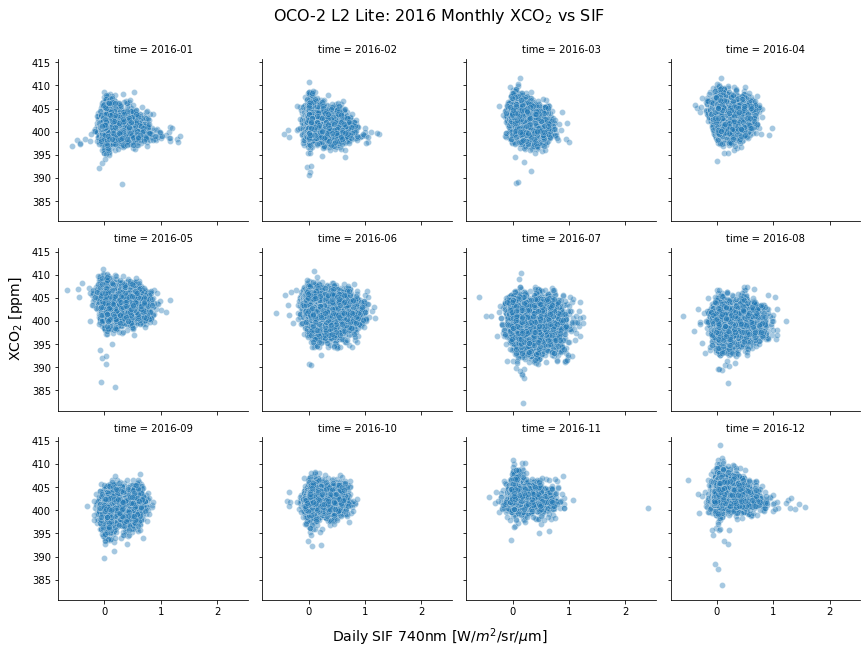

In [48]:
# Make scatter plots faceted by month
g = sns.FacetGrid(df, col="time", col_wrap=4)
g.map(sns.scatterplot, "sif", "xco2", alpha=0.4)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("OCO-2 L2 Lite: 2016 Monthly XCO$_2$ vs SIF", size=16)

#this surpresses the x- and y-labels on each axes of the bottom/leftmost column
g.set_axis_labels("", "") 

# overall ylabel
g.fig.text(x=0, y=0.5, 
           verticalalignment="center",
           s="XCO$_2$ [ppm]",
           size=14,
           rotation=90)

#overall xlabel
g.fig.text(x=0.5, y=0, 
           horizontalalignment="center",
           s="Daily SIF 740nm [W/$m^2$/sr/$\mu$m]", 
           size=14)

plt.savefig("../plots/xco2_vs_sif_2016.png");